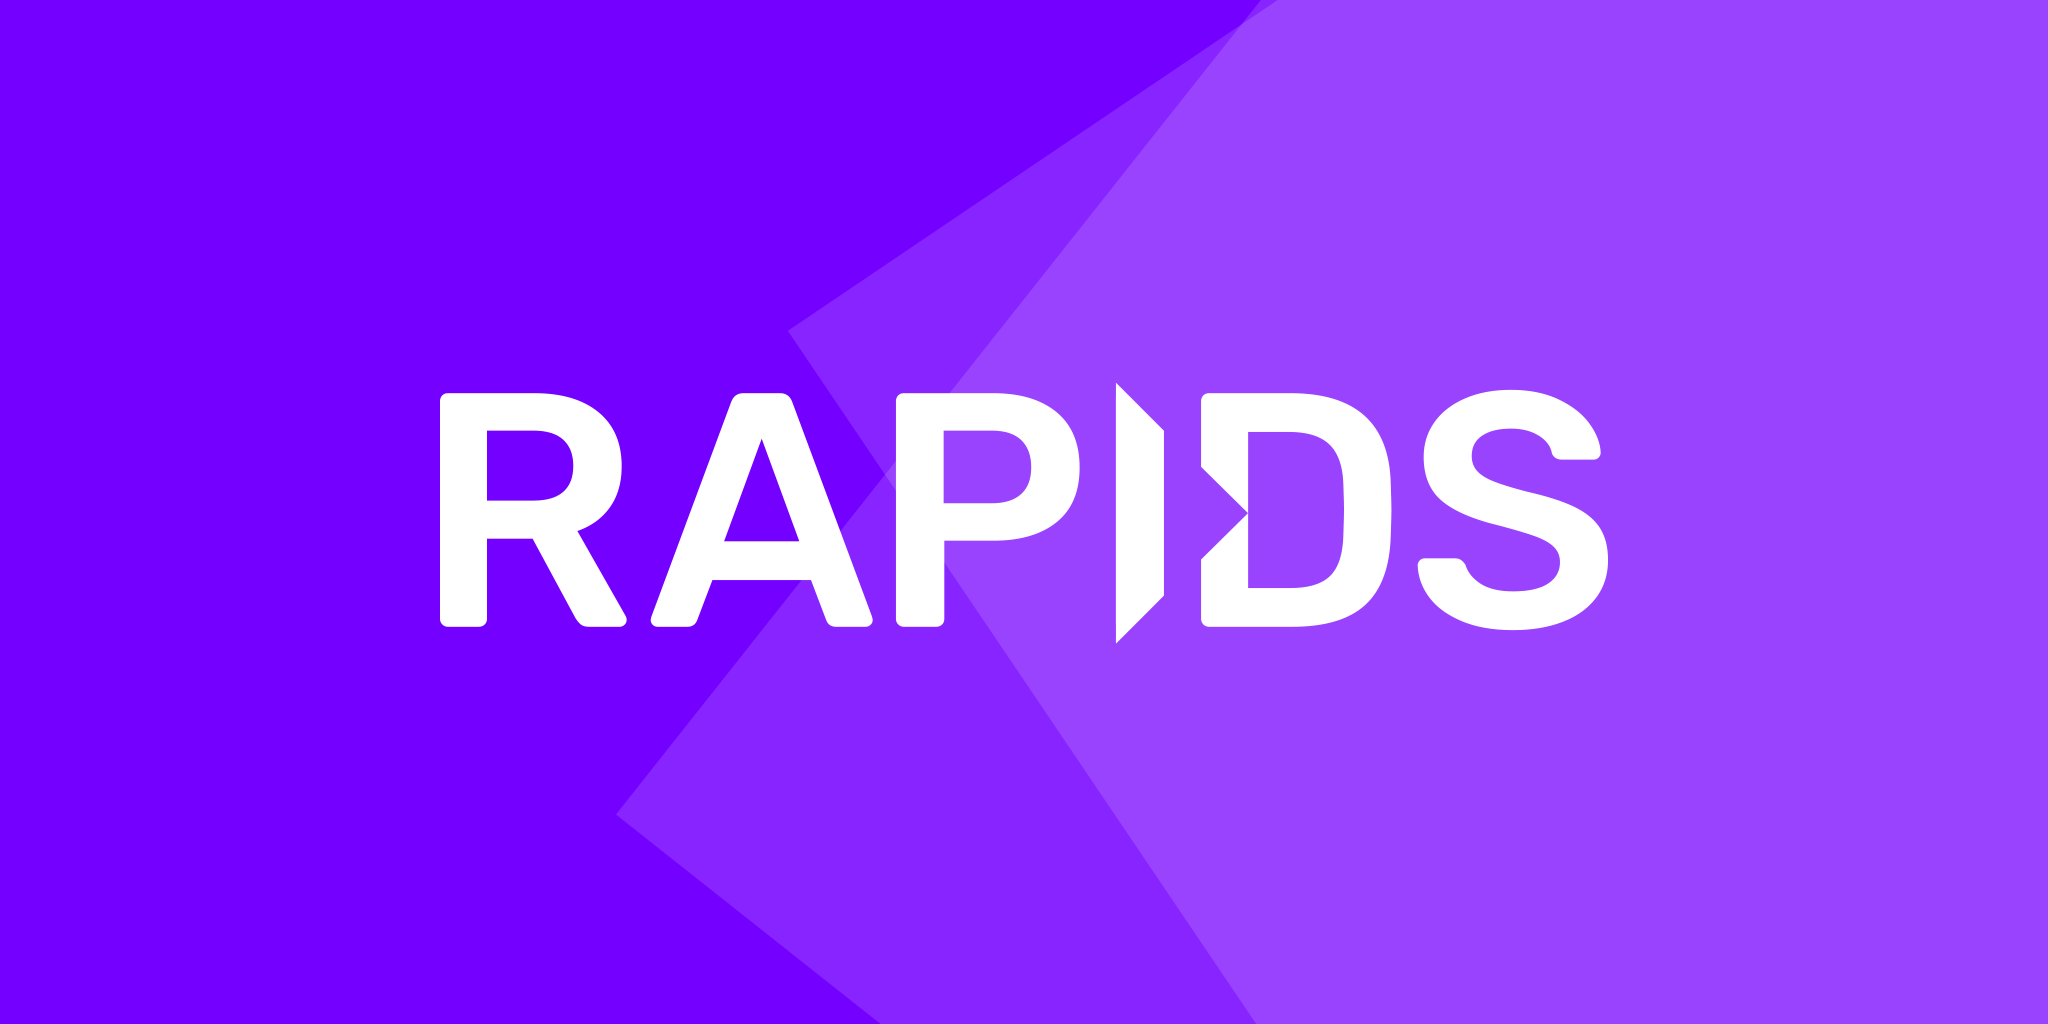

**Here I have tried to come up with different ways to create User Defined Functions in Rapids. Please comment and let me know if you wanna add more functions. </br>
The dataset used is from the recent competition RIID**

In [ ]:
## Get Rapids added in the context
import sys
!cp ../input/rapids/rapids.0.18.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import display_html
from PIL import Image
import gc
from scipy.stats import pearsonr
import tqdm
import copy
import re

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Color Palette
custom_colors = ['#7400ff', '#a788e4', '#d216d2', '#ffb500', '#36c9dd']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [ ]:
import cudf
import cupy # CuPy is an open-source array library accelerated with NVIDIA CUDA.


from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster()
client = Client(cluster)
client

In [ ]:
!nvidia-smi

In [ ]:
import gc
gc.collect()

In [ ]:
%%time

# Read in data
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "int8"
}

train = cudf.read_csv('../input/riiid-test-answer-prediction/train.csv', dtype=dtypes)


##### Perform User Defined Functions


1.Convert to boolean

In [ ]:
from numba import cuda

@cuda.jit
def multiply(in_col, out_col, multiplier):
    i = cuda.grid(1)
    if i < in_col.size: # boundary guard
        out_col[i] = in_col[i] * multiplier

In [ ]:
size = len(train['content_type_id'])
train['content_type_boolean'] = 0.0
multiply.forall(size)(train['content_type_id'], train['content_type_boolean'], 1.0)

#### Cumsum Operations on a group by(hacky way)
Eg: for the above dataset lets filter by a user and create a cumsum of the correct answers

In [ ]:
train=train.set_index(['user_id','timestamp'])


In [ ]:
train.tail(2)

In [ ]:
import gc
gc.collect()

In [ ]:
train=train.reset_index()

In [ ]:
train_user_list=train['user_id'].unique().to_arrow().to_pylist()

In [ ]:
train_test=train[train['user_id'].isin(train_user_list[1:100])]

In [ ]:
from numba import cuda

# Define a function to apply to each group
def cumsum_cals(timestamp,answered_correctly, cumsum_value):

    for i in range(cuda.threadIdx.x,len(timestamp) , cuda.blockDim.x):
        cumsum_value[i] = 0
        for j in range(i+1):

            cumsum_value[i] += answered_correctly[j]



train_test = train_test.groupby("user_id").apply_grouped(cumsum_cals,
                          incols=["timestamp",'answered_correctly'],
                          outcols={
                                    'cumsum_value': np.int64,
                                   },
                          tpb=8)


In [ ]:
train_test[train_test['user_id']==5382]

2. Merge Data Sets

In [ ]:
questions=cudf.read_csv('../input/riiid-test-answer-prediction/questions.csv')
questions.head(1)


In [ ]:
train_test=train_test.merge(questions, how='left', left_on=['content_id'],
           right_on=['question_id'])

In [ ]:
train_test.head(4)

In [ ]:
del questions
gc.collect()